In [ ]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# Load the datasets
local_file_path = 'data/times_local.csv'
cluster_file_path = 'data/times_cluster.csv'

df_local = pd.read_csv(local_file_path)
df_cluster = pd.read_csv(cluster_file_path)

# Display the first few rows of each DataFrame
df_local.head(), df_cluster.head()


In [4]:
#  Remove spaces from column names
df_local.columns = df_local.columns.str.strip()
df_cluster.columns = df_cluster.columns.str.strip()

# Add a 'Machine' column to identify the source
df_local['Machine'] = 'Local'
df_cluster['Machine'] = 'Cluster'

df_combined = pd.concat([df_local, df_cluster], ignore_index=True)

# Convert Execution_Time to numeric in case of any format issues
df_combined['Execution_Time'] = pd.to_numeric(df_combined['Execution_Time'], errors='coerce')

df_combined.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Program         20 non-null     object 
 1   Key             20 non-null     int64  
 2   Plaintext       20 non-null     object 
 3   Search_Phrase   20 non-null     object 
 4   Key_Found       20 non-null     int64  
 5   Decrypted_Text  20 non-null     object 
 6   Execution_Time  20 non-null     float64
 7   Machine         20 non-null     object 
dtypes: float64(1), int64(2), object(5)
memory usage: 1.4+ KB


In [5]:
# Summary statistics
df_combined.describe()

# Checking for missing values
df_combined.isnull().sum()

Program           0
Key               0
Plaintext         0
Search_Phrase     0
Key_Found         0
Decrypted_Text    0
Execution_Time    0
Machine           0
dtype: int64

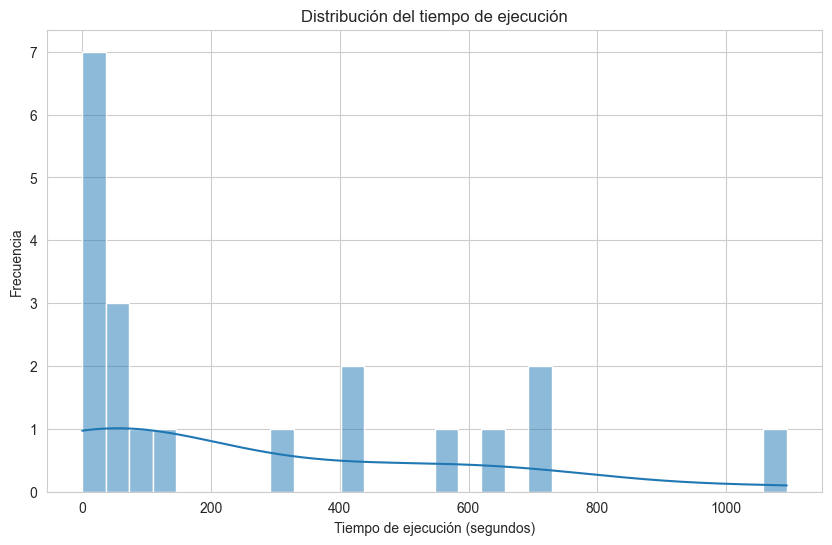

In [6]:
# Distribution of execution times
plt.figure(figsize=(10, 6))
sns.histplot(df_combined['Execution_Time'], bins=30, kde=True)
plt.title('Distribución del tiempo de ejecución')
plt.xlabel('Tiempo de ejecución (segundos)')
plt.ylabel('Frecuencia')
plt.show()


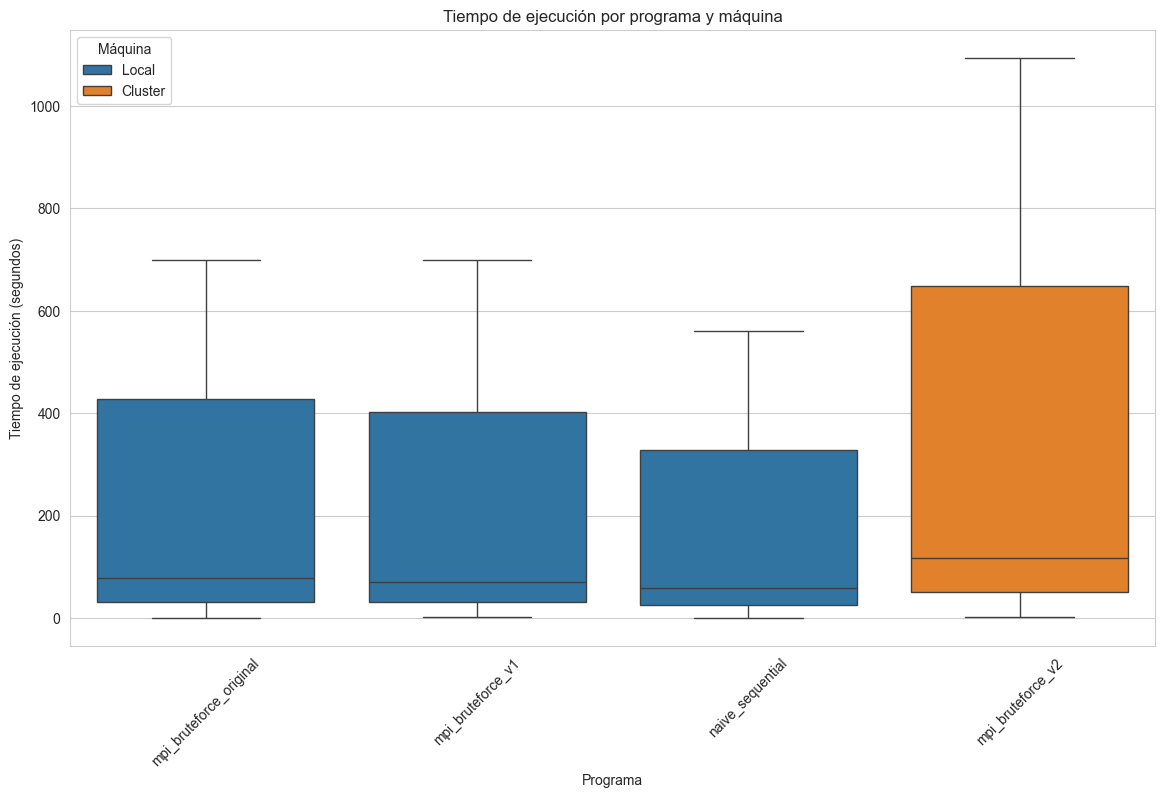

In [7]:
# Boxplot of execution times by program
plt.figure(figsize=(14, 8))
sns.boxplot(x='Program', y='Execution_Time', hue='Machine', data=df_combined)
plt.title('Tiempo de ejecución por programa y máquina')
plt.xlabel('Programa')
plt.ylabel('Tiempo de ejecución (segundos)')
plt.xticks(rotation=45)
plt.legend(title='Máquina')
plt.show()
